# Parallelizing pandas map() and apply() with Dask

Imports:

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from time import sleep

Create data:

In [2]:
d = {
    'a': np.random.randint(20, size=10),
    'b': np.random.randint(20, size=10),
}

Define functions:

In [3]:
def minmax(x):
    sleep(1)
    return x.max() - x.min()

In [4]:
def inc(i):
    sleep(1)
    return i+1

## pandas

In [5]:
df = pd.DataFrame(d)
df

,a,b
0,4,8
1,12,16
2,18,10
3,2,10
4,15,4
5,16,12
6,17,11
7,16,16
8,16,6
9,4,2


In [6]:
%%time
df.apply(minmax, axis=1)

CPU times: user 8.18 ms, sys: 1.37 ms, total: 9.55 ms
Wall time: 10 s


0     4
1     4
2     8
3     8
4    11
5     4
6     6
7     0
8    10
9     2
dtype: int64

In [7]:
%%time
df.a.map(inc)

CPU times: user 2.71 ms, sys: 1.64 ms, total: 4.36 ms
Wall time: 10 s


0     5
1    13
2    19
3     3
4    16
5    17
6    18
7    17
8    17
9     5
Name: a, dtype: int64

In [8]:
%%time
df.applymap(inc)

CPU times: user 5 ms, sys: 2.2 ms, total: 7.2 ms
Wall time: 20.1 s


,a,b
0,5,9
1,13,17
2,19,11
3,3,11
4,16,5
5,17,13
6,18,12
7,17,17
8,17,7
9,5,3


## Dask

In [9]:
import dask.dataframe as dd

In [10]:
ddf = dd.from_pandas(df, npartitions=5)

In [11]:
ddf

,a,b
npartitions=5,,
0,int64,int64
2,...,...
...,...,...
8,...,...
9,...,...


In [12]:
def minmax2(df):
    return df.apply(minmax, axis=1)

In [13]:
%%time
p = ddf.map_partitions(minmax2, meta=(None, 'int64'))
p.compute()

CPU times: user 10.1 ms, sys: 2.23 ms, total: 12.3 ms
Wall time: 2.02 s


0     4
1     4
2     8
3     8
4    11
5     4
6     6
7     0
8    10
9     2
dtype: int64

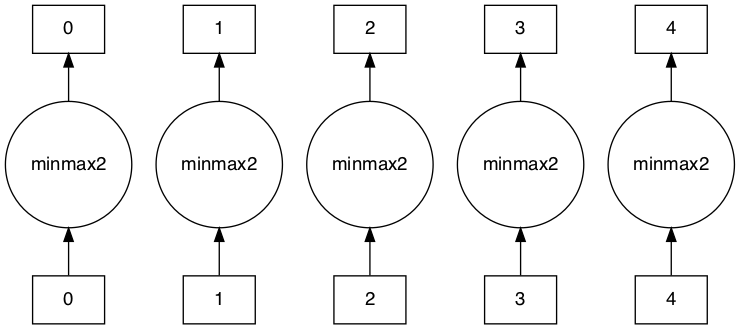

In [14]:
p.visualize()

In [15]:
%%time
q = ddf.apply(minmax, axis=1, meta=(None, 'int64'))
q.compute()

CPU times: user 11.2 ms, sys: 3.16 ms, total: 14.3 ms
Wall time: 2.01 s


0     4
1     4
2     8
3     8
4    11
5     4
6     6
7     0
8    10
9     2
dtype: int64

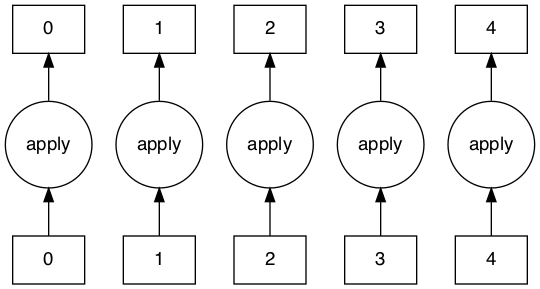

In [16]:
q.visualize()

In [17]:
%%time
r = ddf.a.map(inc, meta=(None, 'int64'))
r.compute()

CPU times: user 3.41 ms, sys: 2.13 ms, total: 5.54 ms
Wall time: 2.01 s


0     5
1    13
2    19
3     3
4    16
5    17
6    18
7    17
8    17
9     5
Name: a, dtype: int64

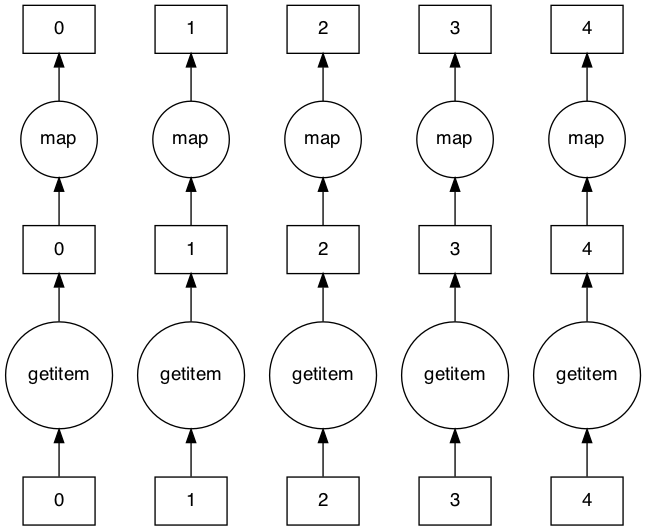

In [18]:
r.visualize()

In [19]:
%%time
s = ddf.applymap(inc, meta=ddf)
s.compute()

CPU times: user 11.3 ms, sys: 3.31 ms, total: 14.6 ms
Wall time: 4.03 s


,a,b
0,5,9
1,13,17
2,19,11
3,3,11
4,16,5
5,17,13
6,18,12
7,17,17
8,17,7
9,5,3


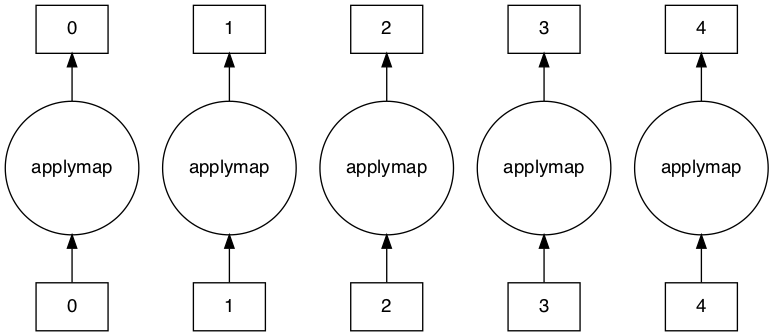

In [20]:
s.visualize()